# Applying Reinforcement Learning to Cartpole
by Thomas Fahrner, Mikey Maramba, and Dhruv Singal


## What is reinforcement learning?
Recent progress in deep learning has expanded beyond unsupervised and supervised learning. Reinforcement learning (RL) is a class of algorithms that establish an action-reward framework to develop an agent that chooses actions to maximize rewards. This framework lends itself to Markov decision processes (MDP). The RL field has flocked to video games since they can often be analyzed as MDPs. OpenAI has created a "gym" where users can download environments (games). Users then train models on these environments in an attempt to converge on a high score.

## Cartpole
Cartpole is an inverted pendulum environment from OpenAI. The goal of Cartpole is to balance the pole in an upright position. Agents have the ability to apply a left or right force on the cart. After each action/timestep, the environment returns an updated state and a reward. The game ends when the pole falls beyond 15 degrees from vertical or the cart extends beyond 2.4 units from the center. To "win" the game, the agent must receive an average reward of 195 over 100 trials. Each "episode" ends when either the game ends or the maximum reward (set by default to 200) is achieved.

The state has four features: [position of cart, velocity of cart, angle of pole, rotation rate of pole] = [p, v, a, r]

The reward is +1 after every timestep.

## Setting up a Cartpole/OpenAI Gym Environment
After installing OpenAI Gym via pip, you can use the core environments that gym provides. The OpenAI Gym Environment provides users with environments and functions used to extract data from the environments for training. The central function is the step function, which returns 4 values: observation, reward, done, and info. Observation stores the 'state' of the game, reward stores the amount of reward achieved by the previous action, and done determines whether to reset the environment or not (info is mostly diagnostic information).

Creating the Cartpole environment is as simple as such:

In [1]:
import gym
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


We will use the function test_params to test the parameter sets that we generate.

In [2]:
def test_params(env, params):
    observation = env.reset()
    total_reward = 0
    while True:
        #env.render()
        res = np.matmul(params, observation)
        if res < 0:
            action = 0
        else:
            action = 1
        observation, reward, done, info = env.step(action)
        #print(observation)
        total_reward += reward
        if done:
            break
    return total_reward

These are the functions we will use to display the results of our algorithms. We will utilize various NumPy utilities and functions to perform matrix operations and use matplotlib to visualize the results of our algorithms' performance.

In [3]:
import numpy as np
from matplotlib import pyplot as plt


env._max_episode_steps = 200  # Cap CartPole maximum reward to this amount
num_samples = 100  # Number of samples to utilize for each algorithm


def runHillClimbing(env):
    num_episodes = []
    for i in range(num_samples):
        res = climb_hill(env)
        if res:
            num_episodes.append(res)

    plt.hist(num_episodes)
    plt.title('Hill Climbing Algorithm')
    plt.xlabel('Episodes')
    plt.ylabel('Frequency')
    plt.show()
    
def runGuessing(env):
    num_episodes = []
    for i in range(num_samples):
        num_episodes.append(run_guesses(env))

    plt.hist(num_episodes)
    plt.title('Random Guessing Algorithm')
    plt.xlabel('Episodes')
    plt.ylabel('Frequency')
    plt.show()
    
def runPolicyGradient(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    model = build_network(num_inputs, num_outputs)
    train = build_train(model, num_outputs)

    steps_per_sample = []
    for sample in range(num_samples):
        for episode in range(5000):
            reward = run_episode(env, train, model, num_outputs)
            if reward == env._max_episode_steps:
                steps_per_sample.append(episode)
                break
        reset_model(model)

    plt.hist(steps_per_sample)
    plt.title('Policy Gradient Algorithm')
    plt.xlabel('Episodes')
    plt.ylabel('Frequency')
    plt.show()

## Our Approach:
We developed a variety of different algorithms to solve Cartpole. Our goals were twofold: gain exposure to the basics of RL and incorporate the deep learning techniques we learned in 490.

## Linear Models

### Random Parameters 
This algorithm involves creating up to N sets of parameters randomly (for our environment, a size of 10,000 parameter sets would be more than sufficient). Each set of parameters were of length 4 and set between -1 and 1. The parameter set was then tested until the game was over. If the current set of parameters achieved a greater amount of reward than the previous maximum, the set would be saved.

In [4]:
def run_guesses(env):
    best_params = None
    best_reward = 0
    t_found = None

    for t in range(10000):  # 10,000 random configurations, 1 each episode
        params = np.random.rand(4) * 2 - 1  # Random weights btwn -1 and 1
        reward = test_params(env, params)
        if reward > best_reward:
            best_reward = reward
            best_params = params
            t_found = t+1
            if reward == env._max_episode_steps:
                break

    return t_found

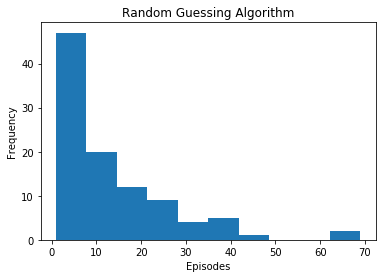

In [5]:
runGuessing(env)

### Hill Climbing
This algorithm involves creating a set of parameters randomly (similar to the random parameters algorithm), testing our initial set of parameters, and then adding “noise” to the parameter set. This noise would be a random set of four numbers between -1 and 1, scaled by a factor of our choice. Similar to the other model, if the current set of parameters achieved a greater amount of reward than the previous maximum, the set would be saved. Noise would be added up to N times.

In [6]:
def climb_hill(env, scale_noise=0.1):
    best_params = None
    best_reward = 0
    t_found = None

    # Start with random setting of the parameters
    params = np.random.rand(4) * 2 - 1

    for t in range(10000):  # Number of iterations to "climb"
        noise = (np.random.rand(4) * 2 - 1) * scale_noise
        params = params + noise  # Add noise matrix to params
        reward = test_params(env, params)
        if reward > best_reward:
            best_reward = reward
            best_params = params
            t_found = t+1
            if reward == env._max_episode_steps:
                break

    if best_reward == env._max_episode_steps:
        return t_found
    else:
        return None  # return 0 if we did not find desired reward

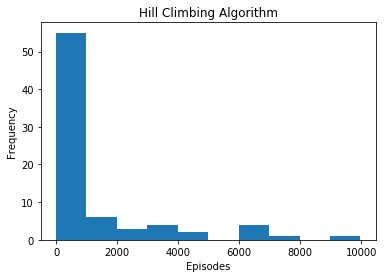

In [7]:
runHillClimbing(env)

## Policy Gradient
We adopted a stochastic policy that defines a probability for each action given the current state. We created a loss and training function to influence the probabilities with the rewards. Our training function considers the difference between the reward seen at a state and the average reward. An action with a reward much larger than the average will have its probability increased for that state.

In [8]:
from keras.models import Model
from keras import layers
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers
from matplotlib import pyplot as plt


def build_network(num_inputs, num_outputs):
    # use Keras functional API to construct policy network
    network = layers.Input(shape=(num_inputs,))
    input = network

    for layer in [32, 16, 8]:
        network = layers.Dense(layer)(network)
        network = layers.Activation("relu")(network)

    network = layers.Dense(num_outputs)(network)
    network = layers.Activation("softmax")(network)

    return Model(inputs=input, outputs=network)


def build_train(model, num_outputs):
    prob_action = model.output
    encoded_action = K.placeholder(shape=(None, num_outputs), name="encoded_action")
    discount_reward = K.placeholder(shape=(None,), name="discount_reward")

    loss = K.mean(-K.log(K.sum(prob_action * encoded_action, axis=1)) * discount_reward)

    deltas = optimizers.Adam().get_updates(params=model.trainable_weights, loss=loss)

    return K.function(inputs=[model.input, encoded_action, discount_reward], outputs=[], updates=deltas)


def get_action(model, state, num_outputs):
    state = np.expand_dims(state, axis=0)
    prob_action = np.squeeze(model.predict(state))

    return np.random.choice(np.arange(num_outputs), p=prob_action)


def fit(train, states, actions, rewards, num_outputs):
    encoded_action = np_utils.to_categorical(actions, num_classes=num_outputs)
    discount_reward = get_discounted(rewards)
    train([states, encoded_action, discount_reward])


def get_discounted(rewards):
    discount_rate = 0.96
    discounted = np.zeros_like(rewards, dtype=np.float32)
    sum = 0

    for t in reversed(range(len(rewards))):
        sum = sum * discount_rate + rewards[t]
        discounted[t] = sum 

    discounted -= discounted.mean() / discounted.std()

    return discounted


def run_episode(env, train, model, num_outputs):
    is_done = False
    state = env.reset()
    states = []
    actions = []
    rewards = []
    total_reward = 0

    while not is_done:
        action = get_action(model, state, num_outputs)
        new_state, reward, is_done, info = env.step(action)
        total_reward += reward

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = new_state

    fit(train, np.asarray(states), np.asarray(actions), np.asarray(rewards), num_outputs)

    return total_reward


def reset_model(model):
    session = K.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

Using TensorFlow backend.


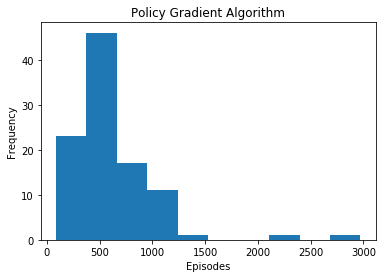

In [9]:
runPolicyGradient(env)

## Deep Q Learning
The set of states and actions, together with rules for transitioning from one state to another, make up a Markov decision process. One episode of this process (e.g. one game) forms a finite sequence of states, actions and rewards:
A Markov decision process relies on the Markov assumption, that the probability of the next state si+1 depends only on current state si and action ai, but not on preceding states or actions.
![title](./MarkovDecision.png)

Given that, the total future reward from time point t onward can be expressed as:
![title](./Rt.png)
Here γ is the discount factor between 0 and 1 – the more into the future the reward is, the less we take it into consideration. 

![title](./policy.png)
Where Q(s, a) represents the maximum discounted future reward when we perform action a in state s, and continue optimally from that point on.

![title](./bellman.png)
This is called the Bellman equation. The main idea in Q-learning is that we can iteratively approximate the Q-function using the Bellman equation.

### Algorithm
![title](./alg.png)

In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
from matplotlib import pyplot as plt
plt.switch_backend('agg')
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')


class DQNetwork:
    def __init__(self, learning_rate=0.01):
        # state inputs to the Q-network
        self.model = Sequential()

        self.model.add(Dense(10, activation='relu', input_dim=4))
        self.model.add(Dense(10, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.optimizer = 'adagrad'
        self.model.compile(loss='mse', optimizer=self.optimizer)


class Memory():
    def __init__(self, max_size=1000):
        self.b = deque(maxlen=max_size)

    def learn(self, exp):
        self.b.append(exp)

    def sample(self, batch_size):
        idx = np.random.choice(
            np.arange(len(self.b)), size=batch_size, replace=False)
        return [self.b[i] for i in idx]


train_episodes = 500  # max number of episodes to learn from
max_steps = 200  # max steps in an episode
gamma = 0.99  # future reward discount
batch_size = 32  # experience mini-batch size
pretrain_length = batch_size  # number experiences to pretrain the memory

mainQN = DQNetwork()
#resest environment before starting to build memory
env.reset()
# do something random to start environment
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, 4])
memory = Memory()

for ii in range(pretrain_length):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 4])

    if done:
        next_state = np.zeros(state.shape)
        memory.learn((state, action, reward, next_state))

        env.reset()
        state, reward, done, _ = env.step(env.action_space.sample())
        state = np.reshape(state, [1, 4])
    else:
        memory.learn((state, action, reward, next_state))
        state = next_state
step = 0
steps_per_sample=[]
# starting episodes from 1
for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    while t < max_steps:
        step += 1
        # env.render()

        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 4])
        total_reward += reward

        if done:
            # the episode ends so no next state
            next_state = np.zeros(state.shape)
            steps_per_sample.append(t)
            t = max_steps
            # print('Episode: {}'.format(ep),
            #       'Total reward: {}'.format(total_reward))
            # Add experience to memory
            memory.learn((state, action, reward, next_state))
            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())
            state = np.reshape(state, [1, 4])
        else:
            # Add experience to memory
            memory.learn((state, action, reward, next_state))
            state = next_state
            t += 1

        # Replay
        inputs = np.zeros((batch_size, 4))
        targets = np.zeros((batch_size, 2))

        minibatch = memory.sample(batch_size)
        for i, (state_b, action_b, reward_b,
                next_state_b) in enumerate(minibatch):
            inputs[i:i + 1] = state_b
            target = reward_b
            if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                target_Q = mainQN.model.predict(next_state_b)[0]
                target = reward_b + gamma * np.amax(
                    mainQN.model.predict(next_state_b)[0])
            targets[i] = mainQN.model.predict(state_b)
            targets[i][action_b] = target
        mainQN.model.fit(inputs, targets, epochs=1, verbose=0)
 #print(steps_per_sample)
plt.hist(steps_per_sample)
plt.title('DQN Algorithm')
plt.xlabel('Episodes')
plt.ylabel('Frequency')
plt.savefig('dqn.png')


Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


![title](./dqn.png)

## Conclusions
Since there are only 4 parameters involved in the Cartpole environment, it is not surprising to see simple algorithms such as Random Parameters consistently outperforming the more computationally intensive algorithms such as Policy Gradient. We found that the Random Paramters converged very quickly, while the Hill Climbing Algorithm tended to converge quickly, but had some outliers (a large range). Policy Gradient and DQN took a large number of episodes to converge because they both learn to estimate a function (neural network). Despite the convergence speed, there are other benefits for using my complicated methods like Policy Gradient or DQN. For environments with higher dimensionality involved in the parameter sets, we would expect to see the more complex algorithms outperform the simple algorithms. With these methods, we can represent an arbitrarily large action space and are guaranteed convergence.

In the future, we intend to use convolutional neural networks to base our decision making on the rendered images instead of basing our decisions on the game's state via the observation property of the environment's step function.

## References
1. https://ai.intel.com/demystifying-deep-reinforcement-learning/ 
2. https://towardsdatascience.com/welcome-to-deep-reinforcement-learning-part-1-dqn-c3cab4d41b6b
3. https://gym.openai.com/
4. https://gym.openai.com/envs/CartPole-v0/
5. http://www.scholarpedia.org/article/Policy_gradient_methods
6. https://www.youtube.com/watch?v=KHZVXao4qXs
